# EOCSI EASI training session 3: Working with SAR data

This notebook will demonstrate how to use Sentinel-1 backscatter to detect the presence of water.

## Introduction to Sentinel-1

Sentinel-1 carries a synthetic aperture radar (SAR) sensor, which can observe our planet even through cloud cover. Sentinel-1's SAR sensor is an active sensor; it emits light in the microwave range of the electormagnetic spectrum, and measures the amount that returns, known as backscatter. Smooth surfaces, like calm water, have very low backscatter - most of the light bounces away from the sensor (known as specular reflection). For rough surfaces, like dirt or vegetation, light is scattered in all directions, producing small backscatter signals (known as diffuse backscatter). Large, human-made structures, which feature both vertical and horizonal smooth surfaces, produce large backscatter signals (known as double bounce). As such, the intensity of Sentinel-1 backscatter can distinguish water from land, as shown in the image below:

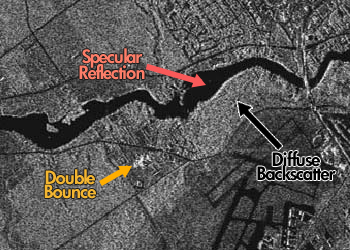

In the image, the river appears dark (specular reflection), with the urban area appearing very bright (double bounce). For more information, see the [article from GIS Geography on SAR](https://gisgeography.com/synthetic-aperture-radar-examples/).

## This workshop

As of this workshop, Sentinel-1 backscatter is not yet available over South East Asia. Instead, this notebook will demonstrate how to load Sentinel-1 backscatter data over Africa, using Digital Earth Africa's [STAC](https://stacspec.org/en) metadata. The Open Data Cube provides [odc-stac](https://odc-stac.readthedocs.io/en/latest/), a useful library for loading data from STAC into an xarray, helping you work with it in the EASI platform. We will use this library in the workshop.

> **Important**: If you want to work with Sentinel-1 as part of your project, please let us know and we can explore options to make data available to you.

The notebook contains the following steps:

1. Import required packages for loading data and analysis
2. Access Sentinel-1 analysis ready data from Digital Earth Africa
3. Visualise data and export a multi-band, single time-slice GeoTIFF
4. Applying speckle filter and converting the digital numbers to decibels (dB) values for analysis
5. Use histogram analysis to determine the threshold for water classification
6. Design a classifier to distinguish land and water
7. Apply the classifier to the area of interest and interpret the results

## Set up

### Import required packages and functions

In [ ]:
%matplotlib inline

# import required packages
import os

import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar
from datacube.utils.cog import write_cog
from dea_tools.plotting import rgb, display_map
from odc.stac import configure_rio, stac_load
from pystac_client import Client
from scipy.ndimage import uniform_filter, variance
from skimage.filters import threshold_minimum

### Make a directory in the tutorials folder to store results in

In [ ]:
# make a results directory to store output

if not os.path.exists("results"):
    os.makedirs("results")

### Configure s3 access

Digital Earth Africa data is stored on S3 in Cape Town, Africa. To load the data, we must configure [rasterio](https://rasterio.readthedocs.io/en/latest/) with the appropriate AWS S3 endpoint. This is done with the [odc.stac.configure_rio](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.configure_rio.html#odc.stac.configure_rio) function.

The configuration below must be used when loading any Digital Earth Africa data through the STAC API.

In [ ]:
# set AWS configuration with specific endpoint
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

### Open Digital Earth Africa's STAC endpoint

Be patient, as this will take a few minutes

In [ ]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")
catalog

## Load Sentinel-1 from the Digital Earth Africa STAC endpoint

The specifics of Digital Earth Africa's Sentinel-1 backscatter product are available in the [Digital Earth Africa Explorer](https://explorer.digitalearth.africa/products/s1_rtc)

The data has five measurements, we will look at two today:

* `vv` is the amount of vertically polarised backscatter received by the sensor
* `vh` is the amount of horizontally polarised backscatter received by the sensor

Polarisation is the orientation of the light relative to the sensor, and different scattering surfaces can effect the backscatter polarisation. In the case of Sentinel-1, the sensor sends out vertically polarised light (`v `) and measures the amount of vertically polarised light (`vv`) or horizontally polarised light (`vh`) returned.

### Steps for loading data

1. Set the configuration
2. Set the query
3. Identify datasets that match the query
4. Load the datasets

### Set Collection Configuration

Digital Earth Africa's Sentinel-1 data (`s1_rtc`) needs to be configured with additional information about the data type and no-data values. This is provided in the dictionary below:

The configuration dictionary is determined from the product’s definition, available at https://explorer.digitalearth.africa/products/s1_rtc

In [ ]:
# VV, VH, AREA = NaN, float32
# angle = 255, uint8
# mask = 0, uint8

# set the collection configuration, setting the products definition
config = {
    "s1_rtc": {
        "assets": {
            "*": {
                "data_type": "float32",
                "nodata": float("nan"),
                "unit": "1",
            },
            "angle": {
                "data_type": "uint8",
                "nodata": 255,
                "unit": "1",
            },
            "mask": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
    }
}

### Define Query Parameters

For this example, we'll use a bounding box, but you could come back an update this to use a polygon by following [training session 2](./Analyse_visualise_export.ipynb)

When working with STAC, we use the word "collection" to refer to a dataset, rather than "product" when working with the ODC. For more information on the differences, see the [odc-stac documentation](https://odc-stac.readthedocs.io/en/latest/stac-vs-odc.html)

In [ ]:
# Set a bounding box using latitude and longitude coordinates
# [xmin, ymin, xmax, ymax]
bbox = [-16.34, 12.5699, -16.24, 12.67]

# timeframe
single_date = "2020"

# Set the STAC collections
collections = ["s1_rtc"]

In [ ]:
# View area of interest
display_map(x=(bbox[0], bbox[2]), y=(bbox[1],bbox[3]))

### Identify datasets that match the query

The connection to Digital Earth Africa's STAC endpoint provides a search function which returns dataset ids matching the parameters of the search. Data can then be loaded by accessing the corresponding files for each id.

In [ ]:
# Build a query with the set parameters
query = catalog.search(bbox=bbox, collections=collections, datetime=single_date)

# Search the STAC catalog for all items matching the query
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

### Load the Data 

In this section we will use the `stac_load` function to only load data within the defined parameters set above. 

This data will be lazy-loaded with dask, meaning the it will not be loaded into memory until required, such as when it is displayed. 

In [ ]:
crs = "EPSG:6933"
resolution = 20

ds = stac_load(
    items,
    bands=[
        "vv",
        "vh",
    ],
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset - loads as dask array
ds

In [ ]:
# Load the data in memory using dask's .compute() function

with ProgressBar():
    ds = ds.compute()

## Visualise the time series

The `vv` and `vh` bands can be viewed individually, or as a RGB style image through combination with their ratio as the third band. 

In [ ]:
# Selecting a few images from the loaded S1 to visualise
timesteps = [2, 4, 6, 9, 11]

In [ ]:
# Plot VV polarisation for specific timeframe
ds.vv.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

In [ ]:
# Plot VH polarisation for specific timeframe
ds.vh.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

For the RGB visualization below, the ratio between VH and VV is added as a third measurement band.

In [ ]:
# VH/VV is a potentially useful third feature after VV and VH
ds["vh/vv"] = ds.vh / ds.vv

In [ ]:
# median values are used to scale the measurements so they have a similar range for visualization
med_s1 = ds.median()

In [ ]:
# plotting an RGB image for selected timesteps
rgb(
    ds[["vv", "vh", "vh/vv"]] / med_s1,
    bands=["vv", "vh", "vh/vv"],
    index=timesteps,
    col_wrap=5,
);

## Export a multi-band, single time-slice GeoTIFF

The next three cells will export the first observation (`time=0`) to a GeoTiff. 

If you want to export multiple observations, refer to [training session 2](./Analyse_visualise_export.ipynb).

In [ ]:
da = ds.to_array()

In [ ]:
rgb_ga = da.isel(time=0)

In [ ]:
write_cog(geo_im=rgb_ga, fname="results/sar_rgb.tif", overwrite=True)

## Apply speckle filtering 

A common processing step when working with SAR data is to remove , which causes SAR data to have a grainy appearence. Radar observations appear [speckly](https://en.wikipedia.org/wiki/Speckle_(interference)) due to random interference of coherent signals from target scatters. The speckle noise can be reduced by averaging pixel values over an area or over time. However, averaging over a fixed window smoothes out real local spatial variation and leads to reduced spatial resolution. An adaptive approach that takes into account local homogeneity is therefore preferred.

Below, we display the unfiltered data, then apply the Lee filter, one of the popular adaptive speckle filters.

In [ ]:
# images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ds["vv"].isel(time=3).plot(ax=ax[0], robust=True)
ds["vh"].isel(time=3).plot(ax=ax[1], robust=True)
ax[0].set_title("VV")
ax[1].set_title("VH")
plt.tight_layout();

In [ ]:
# defining a function to apply lee filtering on S1 image
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    return img_output

Now that we’ve defined the filter, we can run it on the VV and VH data. You might have noticed that the function takes a size argument. This will change how blurred the image becomes after smoothing. We’ve picked a default value for this analysis, but you can experiement with this if you’re interested.

In [ ]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = ds.where(~np.isinf(ds))
ds = ds.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds["filtered_vv"] = ds.vv.groupby("time").apply(lee_filter, size=7)
ds["filtered_vh"] = ds.vh.groupby("time").apply(lee_filter, size=7)

# Null pixels should remain null
ds["filtered_vv"] = ds.filtered_vv.where(valid.vv, np.nan)
ds["filtered_vh"] = ds.filtered_vh.where(valid.vh, np.nan)

In [ ]:
# images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ds["filtered_vv"].isel(time=3).plot(ax=ax[0], robust=True)
ds["filtered_vh"].isel(time=3).plot(ax=ax[1], robust=True)
ax[0].set_title("VV")
ax[1].set_title("VH")
plt.tight_layout();

## Designing a threshold-based water classifier

Similar to [training session 2](./Analyse_visualise_export.ipynb), it is possible to view the histograms for the `vv` and `vh` bands and identify an automatic threshold that seperates two key features in the landscape: water, which has very low backscatter, and land, which has higher backscatter.

When working with radar backscatter, it is common to work with the data in units of decibels (dB), rather than digital number (DN) as measured by the satellite. To convert from DN to dB, we use the following formula:

$$\text{dB} = 10 \times \log_{10}(\text{DN})$$

In [ ]:
# convert digital numbers to dB
ds["filtered_vv"] = 10 * np.log10(ds.filtered_vv)
ds["filtered_vh"] = 10 * np.log10(ds.filtered_vh)

In [ ]:
# histogram analysis for S1
fig = plt.figure(figsize=(12, 3))
ds.filtered_vh.plot.hist(bins=1000, label="VH filtered")
ds.filtered_vv.plot.hist(bins=1000, label="VV filtered", alpha=0.5)
plt.xlim(-40, -1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Comparison of Lee filtered VH and VV polarisation bands");

The `vv` band has a clear separation between the two classes. There is a smaller number of low value pixels, peaking around -30 dB (likely water), and a larger number of high value pixels, peaking around -15 dB (likely land). 

## Build and apply the water classifier

The histogram for VH backscatter shows a bimodal distribution with low values over water and high values over land. The VV histogram has multiple peaks and less obvious seperation between water and land.

We therefore build a classifier based on VH backscatter. We choose a threshold to separate land and water: pixels with values below the threshold are water, and pixels with values above the threshold are not water (land).

There are several ways to determine the threshold. Here, we use the threshod_minimum function implemented in the skimage package to determine the threshold from the VH histogram automatically. This method computes the histogram for all backscatter values, smooths it until there are only two maxima and find the minimum in between as the threshold.

In [ ]:
# Convert to numpy ndarray, remove nan values, and calculate automatic threshold
vh_new = ds["filtered_vh"].values
vh_new = vh_new[~np.isnan(vh_new)]

threshold_vh = threshold_minimum(vh_new)

print(threshold_vh)

In [ ]:
# visualise the threshold
fig, ax = plt.subplots(figsize=(15, 3))
ds.filtered_vh.plot.hist(bins=1000, label="VH filtered")
plt.xlim(-40, -5)
ax.axvspan(xmin=-40.0, xmax=threshold_vh, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold_vh, xmax=-5, alpha=0.25, color="red", label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

In [ ]:
# define the classifier, values lower than the threshold are water pixels, return dataset containing water pixels
def S1_water_classifier(da, threshold=threshold_vh):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

In [ ]:
# return classified data product
ds["water"] = S1_water_classifier(ds.filtered_vh).s1_water
ds

## Assessment with mean 

We can now view the image with our classification. The classifier returns either True or False for each pixel. To investigate the landscape, we want to check which pixels are always water and which are always land. Conveniently, Python encodes `True = 1` and `False = 0`. If we plot the average classified pixel value, pixels that are always water will have an average value of 1 and pixels that are always land will have an average of 0. Pixels that are sometimes water and sometimes land will have an average between these values.

The following cell plots the average classified pixel value over time. What can you learn about the landscape from this summary?

In [ ]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(8, 7))
ds.water.mean(dim="time").plot(cmap="RdBu")
plt.title("Average classified pixel value");

## Assessment with standard deviation

We can also see if the standard deviation of each pixel in time is a reasonable way to learn about the landscape. Similar to how we calculated and plotted the mean above, you can calculate and plot the standard deviation by using the std function in place of the mean function. The standard deviation gives us an idea of how variable a pixel has been over the entire period of time that we looked at.

If you’d like to see the results using a different colour-scheme, you can also try substituting cmap="Greys" or cmap="Blues" in place of cmap="viridis".

In [ ]:
plt.figure(figsize=(8, 7))
ds.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values");

## Practice now

Make a copy of this notebook so that you can keep this one as a reference. Some things you might like to try:

1. Find a different area containing water in Africa and re-run the analysis.
2. Try out a different automatic threshold. How much does it impact the results? See [scikit-image](https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html) for more details about different thresholding methods